                                       Initial Setup: Always run before anything else 

In [1]:
import numpy as np
import os, sys, math, csv, xlwt, operator
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
from xlwt import Workbook 
%matplotlib inline
np.set_printoptions(threshold=np.nan)


In [2]:
#define things about the main star
star_location_x =810
star_location_y =2757
r_main= 3 #radius of main star aperture 
#define thins about comparison stars
comp_star_location_brightness= "07comparison_stars.txt" #name of file to be created with possible reference stars
reference_img_for_comp_stars= "07_east.dat" #reference image
num_stars_to_extract=20 #stars to extract data for 
r_comparison= 3 #radius of comparison star aperture

table_directory = 'reference_txt_files/'
star_folder = table_directory+'star_tables/' #directory of folder in which star tables will be written

comp_star_table2_name="table_mean_RMS.txt"

num_stars_kept=10 #final amount of comparison stars desired
number_of_clippings = 4 #how many times should the clipping method be run
clipping_treshold = 3 # what flux values should be rejected from the analysis, in multiples of RMS


#define things about the cutouts
cutout_directory = 'kn07_cuts/' # location for image cutouts. currently running on only 100ish images
size=200



                                      Creating Image Cutouts ~RUN ONLY ONCE~

In [ ]:
#define things about large images
initial_directory = '/Users/Olive/Desktop/kn07_files/' # path of directory that contains full image fits files

#define things about the main star
cutout_x_start = int(round(star_location_x-size/2))
cutout_x_stop = cutout_x_start+size
cutout_y_start = int(round(roundstar_location_y-size/2))
cutout_y_stop = cutout_y_start+size


all_files=os.listdir(initial_directory) #extract list of files
file_count = len(all_files) # gives number of files in directory
sort_files = sorted(all_files) # sort directory in alphanumeric order
full_img_list = [os.path.join(initial_directory, sort_files[i]) for i in range(0,file_count)] # create file path names for full image files

# a loop to create image cutouts
for i in range(0,file_count):
  #extract data
    full_Image_Data = fits.getdata(full_img_list[i]) #take out data from file (pixel values are in 'section' 1)
    full_Image_Header= fits.getheader(full_img_list[i], ext=1)
  #collect necessary data
    this_data= full_Image_Data[cutout_y_start:cutout_y_stop, cutout_x_start:cutout_x_stop]  #choose area of data to keep
    cutoutName='cutout_'+all_files[i][len(all_files[i])-20:] #appends 'cutout' to the date and id of photo
    destination=cutout_directory+cutoutName  #define destination of new file
  #save the image
    fits.writeto(destination, this_data, full_Image_Header)  #save fits file    
print('cutouts made')

                                     Listing Comparison Stars ~RUN ONLY ONCE~

In [4]:
#RUN ONLY ONCE
# to create a file of stars that are potential candidates for comparison stars to the target
b=open(comp_star_location_brightness,"w+")
b.write("x_coord y_coord brightness distance")

#extract candidate data from .dat file
x_coord, y_coord, brightness, = np.loadtxt(reference_img_for_comp_stars,unpack=True,usecols=(0,1,3))

#create list of stars
with open(reference_img_for_comp_stars, "r") as f:
    Bright_List=[]
    lines = f.readlines()
    i=1
    #collect all stars that are within range
    while i < len(x_coord):
        if i != 0:           
            x_coord_now, y_coord_now, brightness_now=x_coord[i], y_coord[i], brightness[i]    
            Diff_X = abs(float(star_location_x) - float(x_coord_now))
            Diff_Y = abs(float(star_location_y) - float(y_coord_now))  
            
            if (Diff_X+r_comparison) <= size/2  and (Diff_Y+r_comparison) <= size/2: 
                distance = math.sqrt(((abs(Diff_X))**2)+abs((Diff_Y)**2))
                Bright_List.append([x_coord_now,y_coord_now,brightness_now,round(distance,3)])
        i += 1
    #sort by brightness and keep only the brightest stars
    Bright_List.sort(key = lambda x: x[2]) 
    Bright_List_trimmed = Bright_List[0:num_stars_to_extract]  
    
    #write the stars to a file
    b.write('\n')
    for j in Bright_List_trimmed: 
        for k in j:
            b.write(str(k))
            b.write(' ')
        b.write('\n')  
b.close()
print('candidate list created')

candidate list created


                         Collecting flux data to make flux tables ~RUN ONLY ONCE~

In [8]:
# create file path names for cutout image files

cut_files=os.listdir(cutout_directory) #extract list of files
file_count = len(cut_files) # gives number of files in directory
cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]

cutout_data =[]
for i in range (0,file_count):
    image=fits.open(cutout_img_list[i]) #open file
    imageData = image[0].data  #take out data from file (data is in 'section' 1)
    image.close()
    cutout_data.append(imageData)

In [9]:
# define comparison star coordinates and radii from an existing text file 

comparison_stars= np.loadtxt(comp_star_location_brightness, skiprows=1)
comparison_star_circles= [] # empty list for background star circles
for i in range(len(comparison_stars)):
    newStar = comparison_stars[i] #ientify row for clearer use in the next line
    comparison_star_location_x= newStar[0]
    comparison_star_location_y= newStar[1]
    
    # calculate location in terms of local pixels
    location_in_cutout_x= int(round(size/2+(comparison_star_location_x-star_location_x)))
    location_in_cutout_y= int(round(size/2+(comparison_star_location_y-star_location_y)))
    
    # create list of circles to plot, removing those whose aperture doesn't fit in cutout
    if location_in_cutout_x >= r_comparison and location_in_cutout_y >= r_comparison and \
    location_in_cutout_x <= size-r_comparison and location_in_cutout_y <= size-r_comparison:
        comparison_star_circles.append(circle((location_in_cutout_x,location_in_cutout_y-1),r_comparison)) 


In [22]:
x_coord, y_coord = np.loadtxt(comp_star_location_brightness,skiprows=1, unpack=True,usecols=(0,1))
comp_star_info= open(os.path.join(table_directory, "comp_star_info.txt"),"w+")
comp_star_info.write("x_coord y_coord radius \n")


#take star list and change x y coord
###### process of changing location to pixels within the cutout
for i in range(len(x_coord)):
    # calculate location in terms of local pixels
    location_in_cutout_x= int(round(size/2+(x_coord[i]-star_location_x)))
    location_in_cutout_y= int(round(size/2+(y_coord[i]-star_location_y)))
    
    # create list of circles to plot, removing those whose aperture doesn't fit in cutout
    if location_in_cutout_x >= r_comparison and location_in_cutout_y >= r_comparison and \
    location_in_cutout_x <= size-r_comparison and location_in_cutout_y <= size-r_comparison:
        comp_star_info.write(str(location_in_cutout_x)+' '+str(location_in_cutout_y)+' '+str(r_comparison)+ '\n')   
comp_star_info.close()
print('candidate list created')

candidate list created


In [20]:
#write star fluxes into txt file tables, including main star
#a list of all tables, a list of comparison star tables 
star_tables=[]

Mstar_file= open(os.path.join(star_folder, "main_star.txt"),"w+")
Mstar_file.write("time flux clip")
star_tables.append(os.path.join(star_folder,"main_star.txt"))

for j in range(0, len(comparison_stars)):  
    star_file_name= os.path.join(star_folder,"comparison_star_"+str(j)+".txt")
    star_file= open(star_file_name,"w+")
    star_file.write("time flux clip")
    star_tables.append(star_file_name)
comp_star_tables= star_tables[1:]

#insert time and flux data into tables
#loop over all images
for i in range(0, file_count):
    # 5. extract time from cutout file
    image=fits.open(cutout_img_list[i]) #open file
    time_of_flux = image[0].header['JDT']  #take out data from file (data is in 'section' 1)
    image.close()
    for j in range(0, len(star_tables)):  
        # 3. calculate location in terms of local pixels
        if j==0:
            location_in_cutout_x= int(round(size/2))
            location_in_cutout_y= int(round(size/2))
            r=r_main
        else:
            comparison_star_location_x= comparison_stars[j-1][0]
            comparison_star_location_y= comparison_stars[j-1][1]
            location_in_cutout_x= int(round(size/2+(comparison_star_location_x-star_location_x)))
            location_in_cutout_y= int(round(size/2+(comparison_star_location_y-star_location_y)))
            r=r_comparison
        
        aperture=circle((location_in_cutout_x,location_in_cutout_y), r) 

        #4. calculate flux with 'photometry' function for each cutout
        flux_of_star=photometry(cutout_data[i], aperture, method = 'exact') 
        
        # 5. write as flux and time table text file
        
        with open(star_tables[j], 'a') as file:
            file.write("\n" + str(time_of_flux) +" "+ str(flux_of_star[0][3])+" 1")

In [23]:
print(comparison_star_circles)
# maybe instead of creating the circles right away 
# we should just make a table of stars, radii, and x y coordinates in cutout
# and save that

[<CircularAperture([[ 82, 161]], r=3.0)>, <CircularAperture([[82, 56]], r=3.0)>, <CircularAperture([[ 34, 123]], r=3.0)>, <CircularAperture([[147,  72]], r=3.0)>, <CircularAperture([[144,  36]], r=3.0)>, <CircularAperture([[78, 11]], r=3.0)>, <CircularAperture([[77, 58]], r=3.0)>, <CircularAperture([[163,   6]], r=3.0)>, <CircularAperture([[141,  40]], r=3.0)>, <CircularAperture([[73, 15]], r=3.0)>, <CircularAperture([[194, 174]], r=3.0)>, <CircularAperture([[ 41, 163]], r=3.0)>, <CircularAperture([[160,  92]], r=3.0)>, <CircularAperture([[131,  67]], r=3.0)>, <CircularAperture([[ 73, 150]], r=3.0)>, <CircularAperture([[51, 83]], r=3.0)>, <CircularAperture([[21, 29]], r=3.0)>, <CircularAperture([[186, 153]], r=3.0)>, <CircularAperture([[110,  31]], r=3.0)>, <CircularAperture([[99, 53]], r=3.0)>]


                                     Sigma clipping of comparison stars ~RUN ONLY ONCE~

In [24]:
#if cell above was run, comp_star_tebles already exists, else this creates the list
try:
    comp_star_tables
except NameError:
    print('making list')
    comp_star_tables=os.listdir(star_folder)
    comp_star_tables= [os.path.join(star_folder, comp_star_tables[i]) for i in range(len(comp_star_tables))]
    os.listdir(star_folder) #extract list of files
    comp_star_tables.sort(key=len)
    comp_star_tables.pop(0) #remove the first file, which is the main star
else:
    print('it exists')

it exists


In [25]:
#define functions of finding mean and sigma of fluxes
def mean(Array):
    total_flux=0
    num_of_fluxes=0
    for i in range(0, len(Array)):
        if Array[i][2] == 1:
            total_flux +=Array[i][1]
            num_of_fluxes +=Array[i][2]
    return total_flux/num_of_fluxes

def RMS(mean, array):
    diff= []
    for x in range(0,len(array)):
        if array[x][2] == 1:
            diff.append((((array[x][1]-mean)/len(array))**2)**(1/2))
    return sum(diff)

In [26]:
#sigma clipping of flux values by removing values that are above a certain threshold
#current issue: if this was arleady ran once, there are already 0s, so the clipping will be deeper

table_mean_RMS=[] #an array which holds the address of table of a comparison star and its flux mean and rms
#calculate mean and RMS of all stars

comp_stars_table2=open(comp_star_table2_name,"w+")
comp_stars_table2.write("tableName meanValue RMS ")

for i in range(len(comp_star_tables)):
    fluxes=[]    
    #read data of table to an array
    with open(comp_star_tables[i]) as infile:
        line1= True
        for line in infile:
            if line1 == False: 
                fluxes.append([float(line.split()[0]),float(line.split()[1]), int(line.split()[2])])
            line1= False
    #clip 'number_of_clippings' amount of times
    for clip in range(number_of_clippings):
        mean_i = mean(fluxes)
        RMS_i = RMS(mean_i, fluxes)
        #loop through list and remove whatever is outside the range
        for x in range(0, len(fluxes)):
            if abs(fluxes[x][1]-mean_i)>(clipping_treshold*RMS_i):
                fluxes[x][2] = 0

    #create table with star addresses and their MEAN and RMS
    table_mean_RMS.append([i, comp_star_tables[i],mean_i,RMS_i])
    
    comp_stars_table2.write("\n" + str(i) +" "+str(comp_star_tables[i]) +" "+ str(mean_i) + " " + str(RMS_i))
   

    #rewrite file to have 0 values
    star_file= open(os.path.join(star_folder,"comparison_star_"+str(i)+".txt"),"w+")
    star_file.write("time flux clip")
    for j in range(0, len(fluxes)):
        star_file.write("\n" + str(fluxes[j][0]) +" "+ str(fluxes[j][1])+" "+ str(fluxes[j][2]))
    star_file.close()
    
comp_stars_table2.close()

                                    Choose least variable stars for comparison

In [7]:
#define functions for sorting the stars and collect circular apertres for wanted ones
def sort_table(table, col):
    return sorted(table, key=operator.itemgetter(col))

def removeCompStars(array, amountKept, table):
    comparison_star_circles=[]
    for num in range (0, amountKept):
        circle_to_add=comp_stars_table2[num][0]    
        comparison_star_circles.append(array[circle_to_add])
    return comparison_star_circles

#######create table_mean_rms table of only chosen reference stars######
##### open comparison star circles table to choose only wanted ones#####


#sort the star table and create array of wanted stars then save chosen strs into file
table_mean_RMS= sort_table(table_mean_RMS,3)
chosen_comparison_star_circles=removeCompStars(comparison_star_circles, num_stars_kept, table_mean_RMS)




NameError: name 'comparison_star_circles' is not defined

In [ ]:
for item in range(len(chosen_comparison_star_circles)):
    print(chosen_comparison_star_circles[item])

                              ~  Light Curve and Phase Curve Production ~

                                     Producing Reference Images

In [37]:
# variables for the graphs

display_file = 0 # target file number to display target image. It can stay hardcoded, it's only for our reference

x_aperture = 9 # x coordinate of target aperture center within the star cutout 
y_aperture = 11 # y coordinate of target aperture center within the star cutout 
r = 3 # radius of target aperture

x_background = x_aperture # x coordinate of background annulus center
y_background = y_aperture # y coordinate of background annulus center
r_in = 8 # inner radius of background annulus (in pixels)
r_out = r_in + 1 # outer radius of background annulus

#a size large enough for the background annulus with 2px of padding on each side
target_img_size= (r_out+2)*2 # x by x pixel size of target image

low_period = 1.5 # lowest period for LombScargle to test on target star (days)
high_period = 500# highest period for LombScargle to test on target star (days)

In [38]:
#define placement of main star apreture on images

center = size/2 # calculate center location of target image
target = cutout_data[display_file][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] # create array of target image data values for specified file
aperture_main_cutout = circle((x_aperture,y_aperture), r) # create circular aperture around target
background_main_cutout = annulus((x_background,y_background), r_in, r_out) # create annulus for background flux

#place aperture and annulus of main star on large image
offset = (len(cutout_data[display_file])-target_img_size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture_large_cutout = circle((x_aperture+offset,y_aperture+offset), r) # place aperture on target star in comparison stars image
background_large_cutout = annulus((x_background+offset,y_background+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image

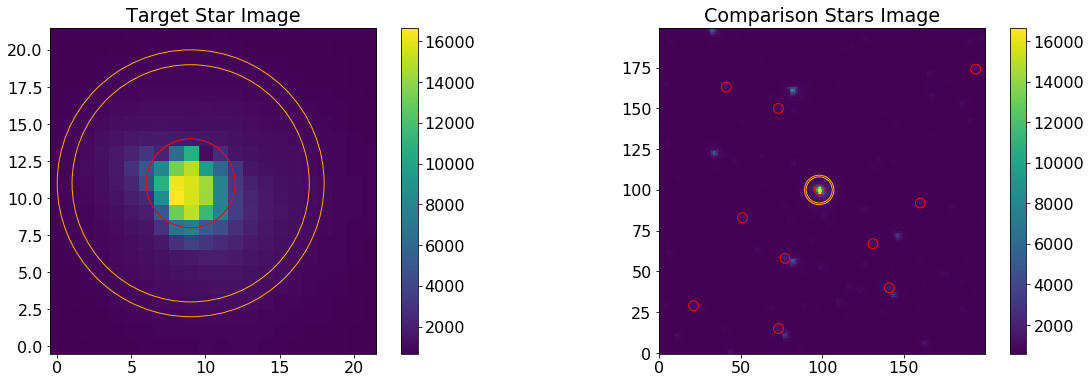

In [39]:
# create target image with target aperture and background annulus
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

def target_star_image():
    plt.subplot(121)
    plt.title('Target Star Image')
    plt.imshow(target, origin='lower')
    plt.colorbar()
    aperture_main_cutout.plot(color='red')
    background_main_cutout.plot(color='orange')

# create comparison stars image with target aperture, comparison apertures, and background annulus
def comparison_star_image():
    plt.subplot(122)
    plt.title('Comparison Stars Image')
    plt.imshow(cutout_data[display_file], origin='lower')
    plt.colorbar()
    aperture_large_cutout.plot(color='red')
    background_large_cutout.plot(color='orange')
    for i in range(len(chosen_comparison_star_circles)):
        chosen_comparison_star_circles[i].plot(color='red')

target_star_image()
comparison_star_image()
plt.show()


                                             Star Flux vs. Time

In [41]:
time=[]
table=np.loadtxt(comp_star_tables[0], skiprows=1)
for line in range(0,len(table)):
    time.append(table[line][0])

In [42]:
#allow user to choose time frame for analysis

beginning_timestamp=0
end_timestamp=len(time)-1

if input("custom time frame? y/n: ")== 'y':
    beginning_input=int(input ("input beginning JDT date "))
    end_input=int(input ("input ending JDT date "))

    for i in range (0, len(time)):
        if beginning_input <= time[i]:
            beginning_timestamp= i
            break

    for i in range (beginning_timestamp, len(time)):
        if end_input <= time[i]:
            end_timestamp= i
            break

print(beginning_timestamp)
print(end_timestamp)

custom time frame? y/n: n
0
4611


In [43]:
main_star_flux, main_star_time=[],[]
with open(os.path.join(star_folder, "main_star.txt"),'r') as f:
    next(f)
    for line in f:
        main_star_flux.append(float(line.split()[1]))
        main_star_time.append(float(line.split()[0]))
    f.close()
    
normalized_main_star_flux=[(main_star_flux[i])/max(main_star_flux) for i in range(0,len(main_star_flux))]


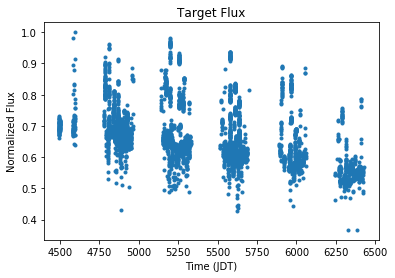

In [44]:
normalized_target_flux = normalized_main_star_flux  
time =main_star_time

#create flux v. time plot
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
      
#rounding x tick marks
roundDecimals=2
difference=(max(time)+1-min(time))

while difference>=10:
    difference= difference/10
    roundDecimals=roundDecimals-1
if difference<=1:   
    roundDecimals=roundDecimals-2
    while difference<=1:
        difference= difference/10
        roundDecimals=roundDecimals+1

#plotting    
graphing_time=[time[i]-2450000 for i in range(0,len(time))]
#print(graphing_time)

graphing_time= graphing_time[beginning_timestamp:end_timestamp]
normalized_target_flux= normalized_target_flux[beginning_timestamp:end_timestamp]

def target_star_flux_graph():
    plt.title('Target Flux') 
    #plt.xticks(np.arange(round(min(time),roundDecimals), max(time)+1, round((max(time)+1-min(time))/5,roundDecimals)))
    plt.plot(graphing_time, normalized_target_flux, '.')

target_star_flux_graph()
plt.show()

                                   Comparison Star Flux vs. Time

In [45]:
#extract candidate data from .dat file
#x_coord, y_coord, brightness, = np.loadtxt(reference_img_for_comp_stars,unpack=True,usecols=(0,1,3))

####### make a table to hold all comp star fluxes by timestamp  ########
# use flux*clip value for the flux values to make sure we disregard unwanted values
# use total fluxes for each line to count how many non-0 values are in the line
#table format:
#  timeStamp  compStar0 compStar2 ... compStar19 totalFluxes 
#
#
#
####### and then make a table of timestap and avg comp star flux ########
####### using sumOfFluxes/totalFluxes for each line #######
#the stuff we have elow is not right
comp_star_list= open(comp_star_table2_name, 'r')
comp_star_fluxes=[[]]
print(comp_star_list)
for i in range(len(comp_star_list)):
    compStar = comp_star_list[i][1] #ientify row for clearer use in the next line
    with open(os.path.join(compStar),'r') as f:
        next(f)
        for line in f:
            if line.split()[2]==1:
                flux = line.split()[1]
            else:
                flux = 0
            comp_star_fluxes[line].append(flux)
print(comp_star_fluxes)
        
#normalized_main_star_flux=[(main_star_flux[i])/max(main_star_flux) for i in range(0,len(main_star_flux))]

FileNotFoundError: [Errno 2] No such file or directory: 'table_mean_RMS.txt'

In [200]:
#### once the previous cell is good, this cell will not be necessary other than the last line ###

# sum up exact amount of flux contained in each comparison star aperture
comparison_sum = 
comparison_sum = [[photometry(cutout_data[i], comparison_star_circles[j], method = 'exact') 
                   for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))]

# multiply background median by area of each aperture to get background flux contained in each aperture
comparison_background_sum = [[background_median[i] * comparison_star_circles[j].area() 
                              for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))]

# subtract background flux in each aperture from each aperture's total flux
comparison_subtract = np.array([[comparison_sum[j][i]['aperture_sum'] - comparison_background_sum[j][i] 
                                 for i in range(0,file_count)] for j in range(0,len(comparison_star_circles))]) 

comparison_total = comparison_subtract.sum(axis=0) # sum up the background subtracted flux for all comparison stars
comparison_flux = comparison_total[comparison_total != 0] # disregard zero flux values

normalized_comparison_flux= comparison_flux/max(comparison_flux)


SyntaxError: invalid syntax (<ipython-input-200-46e122a6d147>, line 4)

In [ ]:
# create comparison flux vs. time plot
plt.subplot(122)
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')

normalized_comparison_flux= normalized_comparison_flux[beginning_timestamp:end_timestamp]
def comparison_stars_flux_graph():
    plt.title('Comparison Flux')
    #plt.xticks(np.arange(round(min(time),roundDecimals), max(time)+1, round((max(time)+1-min(time))/5,roundDecimals)))
    plt.plot(graphing_time, normalized_comparison_flux, '.')
        
comparison_stars_flux_graph()
plt.show()

In [ ]:
# subtract target flux from comparison flux then use Lomb-Scargle Periodogram to test period range on target 

final_flux = np.subtract(target_flux, comparison_flux) 
frequency, power = LombScargle(time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 

phase_offset = 0.5 - np.remainder(time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
phase = np.remainder(time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles


In [ ]:
# create target light curve with target flux minus comparison flux vs. time 
plt.title('Target Light Curve')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
#plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))

final_flux= final_flux[beginning_timestamp:end_timestamp]

plt.plot(graphing_time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
plt.show()

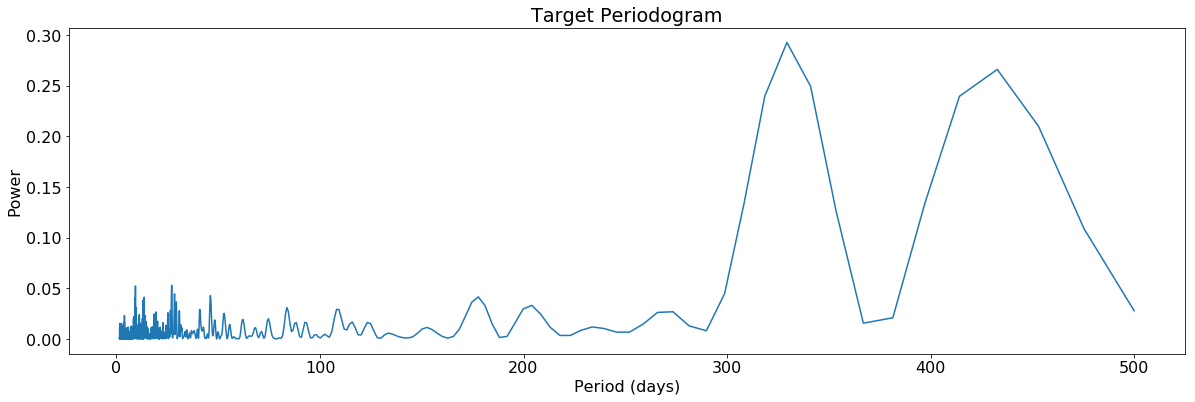

best period for range 1.5 to 500 days = 329.4034678659675 days
power value for best period =  0.29262927052793386


In [201]:

# create target periodogram with power vs. period
plt.plot(1/frequency, power)
plt.title('Target Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()
# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

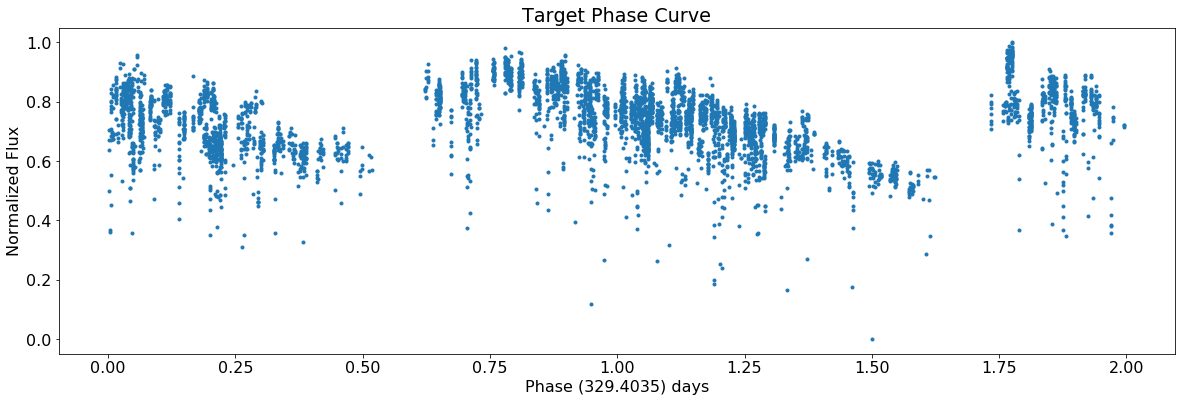

In [202]:
# create target phase curve with flux vs. phase
phase= phase[beginning_timestamp:end_timestamp]

plt.plot(phase, (final_flux - min(final_flux))/max(final_flux-min(final_flux)), '.')
plt.title('Target Phase Curve')
xLabel= 'Phase ('+ str(round(period,4))+ ') days'
plt.xlabel(xLabel)
plt.ylabel('Normalized Flux')
plt.show()

                                                Creating Flux Histogram

In [22]:
# cell for upcoming variables not previously defined

bin_size = 2500 # bin size for histogram

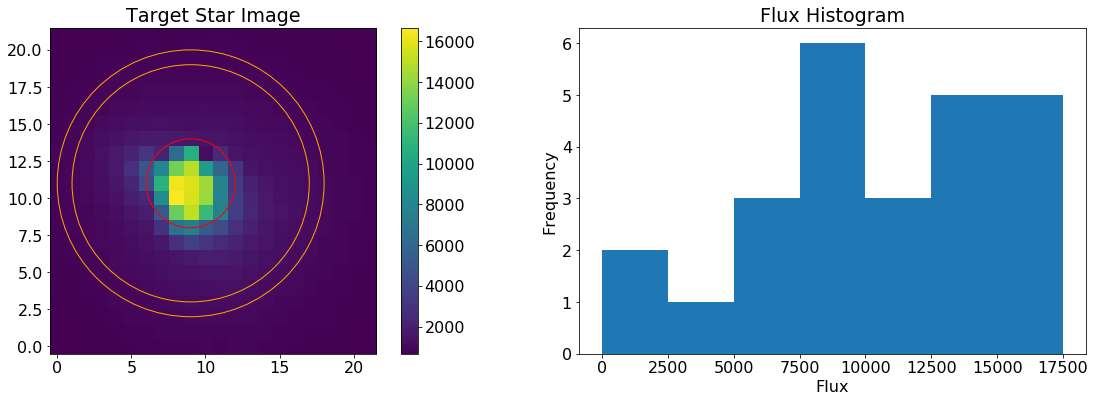

In [23]:
# create target image with target aperture and background annulus


aperture_mask = aperture_main_cutout.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

# create bins for histogram up to highest flux value in aperture
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) 

# create flux histrogram of values within target aperture
plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
target_star_image()
plt.show()

                                            Examining Abnormal Flux Values

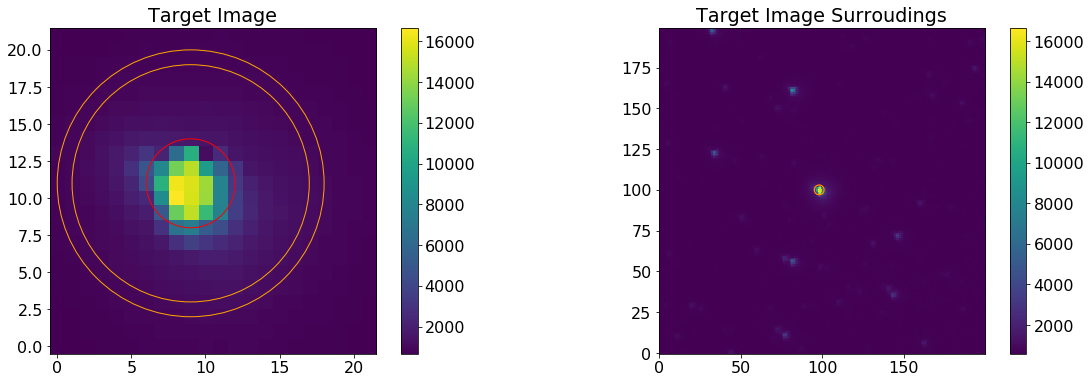

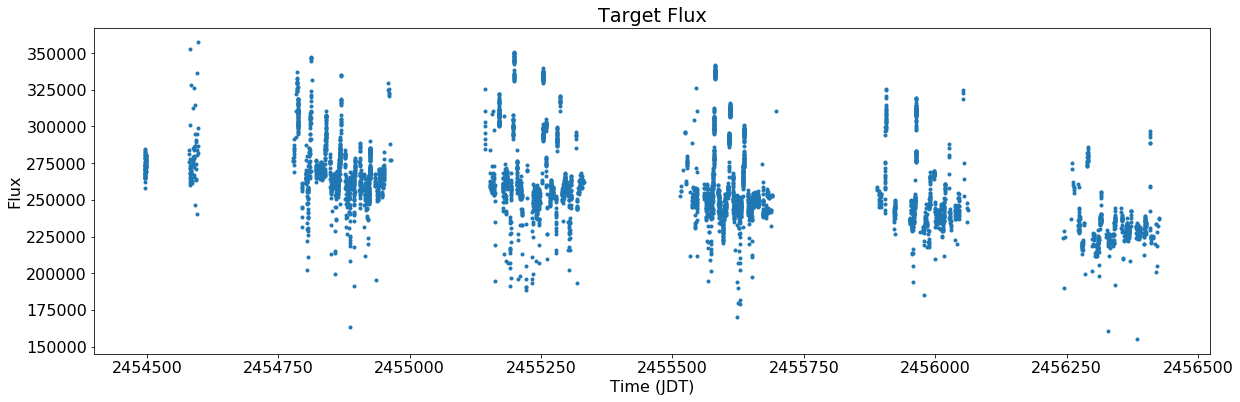

Low Flux Values

File    Target Flux



High Flux Values

File    Target Flux


In [24]:

# create target image with target aperture and background annulus
plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

target_data = [cutout_data[i][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] for i in range(0,file_count)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture_main_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,file_count)]) # get flux of target aperture without disregarding zero flux values


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(cutout_data[display_file], origin='lower')
plt.colorbar() 
aperture_large_cutout.plot(color='red') 
aperture_large_cutout.plot(color='orange')
plt.show()

#redefine time to contain timestamps even of 0 flux images
alltime=[]
for i in range(0,len(cutout_data)):
    cutout_file = fits.open(cutout_img_list[i])
    alltime.append(cutout_file[0].header['JDT'])
    cutout_file.close

# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
#plt.xticks(np.arange(round(min(alltime),-2), max(alltime)+1, round((max(alltime)+1-min(alltime))/10,-2)))
plt.plot(alltime, target_flux, '.')
plt.show()


low_flux = 100000
high_flux = np.inf # upper limit for target flux values


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "        ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "        ", target_flux[target_flux > high_flux][i])